In [5]:
import tomlkit
import json
import numpy as np
from pathlib import Path

step = 100
log_dir = Path("records/bc5cdr-1.0/mproto/confusion/2022-12-23_17-47-12.791247")
# step = 150
# log_dir = Path("records/conll03-1.0/mproto/confusion/2022-12-29_15-38-08.957818")

ids_path = log_dir / "detail_log" / "assignments{}.json".format(step)
assignments_path = ids_path.with_name(ids_path.stem + ".npy")

with (log_dir / "cfg.toml").open('r', encoding="utf8") as rf:
    cfg = tomlkit.load(rf)
num_proto_per_type = cfg["model"]["num_proto_per_type"]
for pipe in cfg["task"]["datasets"]["train"]["pipes"]:
    if pipe["type"] == "alchemy.pipeline.lst.SequenceWrapper":
        samples_path = Path(pipe["datapipe"][0])
meta_path = Path(cfg["task"]["meta"])

with meta_path.open('r', encoding="utf8") as rf:
    meta = json.load(rf)
id2type = ["None"]
# specified entity types
for i, (key, v) in enumerate(meta['entities'].items()):
    if key == "None":
        pass
    else:
        id2type.append(key)
type2id = {v: i for i, v in enumerate(id2type)}

id2sample = {}
with samples_path.open('r', encoding="utf8") as rf:
    for line in rf:
        sample = json.loads(line)
        labels = np.zeros(len(sample["tokens"]), dtype=int)
        for m in sample["entities"]:
            labels[m["start"]:m["end"]] = type2id[m["type"]]
        sample["labels"] = labels
        hu_labels = np.zeros(len(sample["tokens"]), dtype=int)
        for m in sample["human_entities"]:
            hu_labels[m["start"]:m["end"]] = type2id[m["type"]]
        sample["hu_labels"] = hu_labels
        id2sample[sample["id"]] = sample

assignments = np.load(assignments_path)
print(assignments.shape)
batches = []
batch_nones = []

with ids_path.open('r', encoding="utf8") as rf:
    ids = json.load(rf)
    for batch_ids in ids:
        batches.append([])
        batch_nones.append(0)
        for sample_id in batch_ids:
            sample = id2sample[sample_id]
            batches[-1].append(sample)
            batch_nones[-1] += sum(sample["labels"] == 0)

assert sum(batch_nones) == len(assignments)
pivots = np.cumsum(np.asarray(batch_nones))
assignments = np.split(assignments, pivots)
confusion_mat = np.zeros((len(id2type) - 1, len(id2type)), dtype=int)       # hard confusion or soft ?
for batch, b_assignments in zip(batches, assignments):
    hu_labels = []
    for sample in batch:
        for label, hu_label in zip(sample["labels"], sample["hu_labels"]):
            if label == 0:
                hu_labels.append(hu_label)
    assert len(hu_labels) == b_assignments.shape[0], "{} != {}".format(
        b_assignments.shape, hu_labels
    )
    for assignment, hu_label in zip(b_assignments, hu_labels):
        if hu_label == 0:
            # 本来就是噪声
            continue
        else:
            hu_label -= 1
        assigned_pid = np.argmax(assignment)
        assigned_tid = assigned_pid // num_proto_per_type
        confusion_mat[hu_label, assigned_tid] += 1

print(confusion_mat)



(110219, 9)
[[ 117 2357  139]
 [  10   49 3711]]


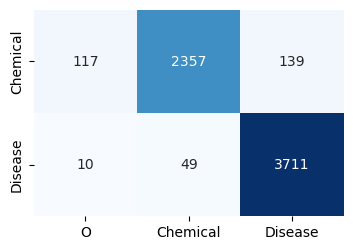

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 7))
display_ptypes = list(id2type)
display_ptypes[0] = "O"         # 为了和论文一致将None改成O
sns.heatmap(
    confusion_mat, annot=True, fmt="d",square=True, cmap="Blues",
    cbar=False,
    xticklabels=display_ptypes, yticklabels=id2type[1:],
)
plt.show()